#***SKIM LIT***

The purpose of this notebook is to create a model which makes the reading of abstracts easier

In other words given the abstract of a RCT, what role does each sentence serve in the abstract?

This notebook is adapted from the Milestone Project 2 of the [Tensorflow Course offered by ZTM](https://dev.mrdbourke.com/tensorflow-deep-learning/10_time_series_forecasting_in_tensorflow/)

The papers being implemented are:  

[PubMed 200k RCT: a Dataset for Sequenctial Sentence Classification in Medical Abstracts.](https://arxiv.org/abs/1710.06071)

[Neural networks for joint sentence classification in medical paper abstracts.](https://arxiv.org/pdf/1612.05251.pdf)


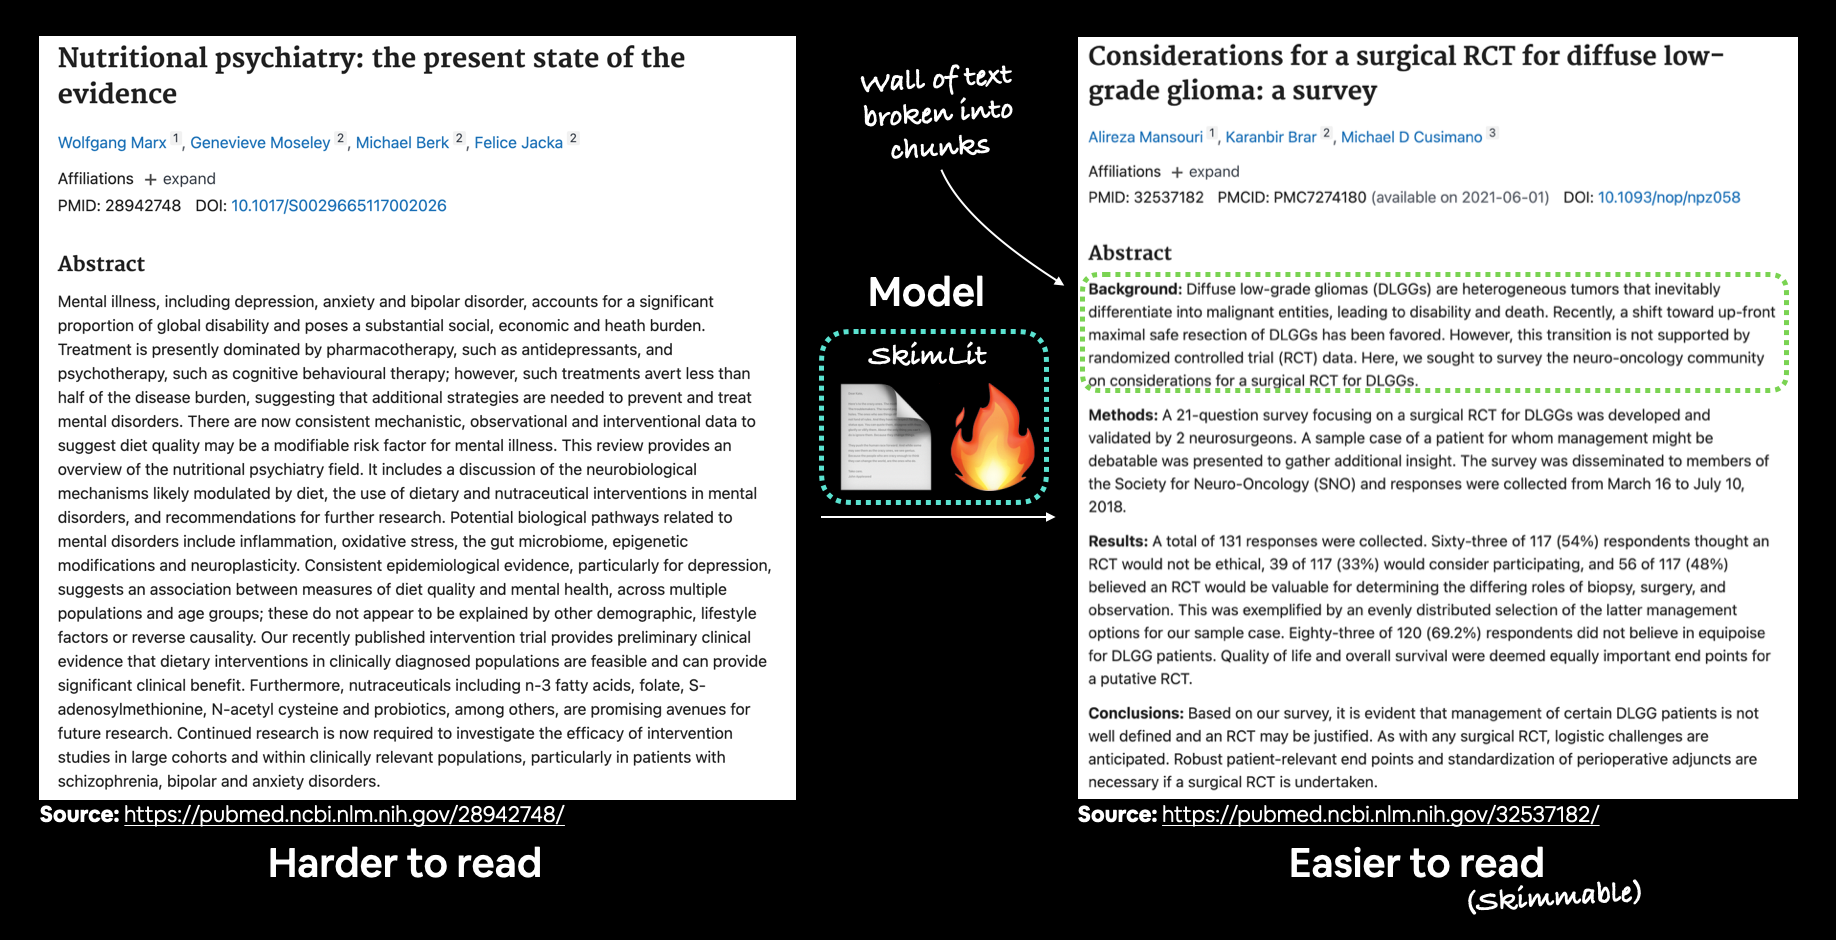

Check GPU

In [ ]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-72dab0a9-b0ee-daac-986b-0b0969155b1c)


Link drive to colab

In [ ]:
from google.colab import drive

drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
cd '/content/gdrive/MyDrive/SkimLit'

/content/gdrive/MyDrive/SkimLit


##Data Preperation



Download the data from the mrdbourke/tensorflow-deep-learning repository

In [ ]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct

fatal: destination path 'pubmed-rct' already exists and is not an empty directory.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


Lets use the 20k dataset where numbers have been replaced with @

In [ ]:
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign

dev.txt  test.txt  train.txt


In [ ]:
dataDir = "pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign"

In [ ]:
import os

files = [files for files in os.listdir(dataDir)]

print(f"""
  We have the train data {files[0]}
  We have the test data {files[2]}
  We have the dev data {files[1]}
""")


  We have the train data dev.txt
  We have the test data train.txt
  We have the dev data test.txt



Our data is in the form of a text file , so preprocessing is required

In [ ]:
def readFile(pathName):

  """
  Read a file and return a list of lines

  Args: Path to file

  Returns: List of lines
  """

  fileReader = open(pathName,'r')

  return fileReader.readlines()

In [ ]:
lines = readFile("pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt")
lines[-30:]

['###25653511\n',
 'BACKGROUND\tThe objective of this study was to assess the efficacy and safety of alfuzosin @ mg monotherapy or combined antihypertensive medication on blood pressure ( BP ) in patients with lower urinary tract symptoms suggestive of benign prostatic hyperplasia ( BPH/LUTS ) with or without antihypertensive medication .\n',
 'METHODS\tThis was a @-month , multicenter , randomized , open-label study in @ patients aged @ years with a clinical diagnosis of BPH/LUTS by medical history and clinical examination , a total International Prostatic Symptom Score ( IPSS ) @ points , a maximum flow rate > @ mL/sec and @ mL/sec , and a voided volume @ mL .\n',
 'METHODS\tEligible subjects were randomized to receive alfuzosin @ mg as monotherapy ( group @ ) or alfuzosin @ mg + antihypertensive combination therapy ( group @ ) .\n',
 'METHODS\tBased on baseline BP and hypertensive history with or without antihypertensive medications at first medical examination , group @ was divided

We want our data in the following format

```
[{'line_number': 0,
  'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'total_lines': 11},
  ...]
```

In [ ]:
linesSubSet = lines[-10:]

for i in linesSubSet:
  print(i.split("\t"))

['RESULTS', 'A total of @ patients received at least one study-drug dose .\n']
['RESULTS', 'In the active-regimen group , @ of @ patients had a sustained virologic response at post-treatment week @ , for an overall rate of @ % ( @ % confidence interval , @ to @ ) .\n']
['RESULTS', 'This rate was noninferior and superior to the historical control rate .\n']
['RESULTS', 'Rates were @ % among patients with a prior relapse ( @ of @ patients ) , @ % among patients with a prior partial response ( @ of @ patients ) , and @ % among patients with a prior null response ( @ of @ patients ) .\n']
['RESULTS', 'Pruritus occurred more frequently with the active regimen ( in @ % of patients ) than with placebo ( @ % , P = @ ) .\n']
['RESULTS', 'Three patients in the active-regimen group ( @ % ) discontinued the study drugs owing to adverse events .\n']
['RESULTS', 'Hemoglobin values of grade @ ( @ to < @ g per deciliter ) and grade @ ( @ to < @ g per deciliter ) occurred in @ % and @ % of patients in 

In [ ]:
def preprocess_text_with_line_numbers(filename):
  """Returns a list of dictionaries of abstract line data.

  Takes in filename, reads its contents and sorts through each line,
  extracting things like the target label, the text of the sentence,
  how many sentences are in the current abstract and what sentence number
  the target line is.

  Args:
      filename: a string of the target text file to read and extract line data
      from.

  Returns:
      A list of dictionaries each containing a line from an abstract,
      the lines label, the lines position in the abstract and the total number
      of lines in the abstract where the line is from. For example:

      [{"target": 'CONCLUSION',
        "text": The study couldn't have gone better, turns out people are kinder than you think",
        "line_number": 8,
        "total_lines": 8}]
  """
  input_lines = readFile(filename) # get all lines from filename
  abstract_lines = "" # create an empty abstract
  abstract_samples = [] # create an empty list of abstracts
  
  # Loop through each line in target file
  for line in input_lines:
    if line.startswith("###"): # check to see if line is an ID line
      abstract_id = line
      abstract_lines = "" # reset abstract string
    elif line.isspace(): # check to see if line is a new line
      abstract_line_split = abstract_lines.splitlines() # split abstract into separate lines

      # Iterate through each line in abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # create empty dict to store data from line
        target_text_split = abstract_line.split("\t") # split target label from text
        line_data["target"] = target_text_split[0] # get target label
        line_data["text"] = target_text_split[1].lower() # get target text and lower it
        line_data["line_number"] = abstract_line_number # what number line does the line appear in the abstract?
        line_data["total_lines"] = len(abstract_line_split) - 1 # how many total lines are in the abstract? (start from 0)
        abstract_samples.append(line_data) # add line data to abstract samples list
    
    else: # if the above conditions aren't fulfilled, the line contains a labelled sentence
      abstract_lines += line
  
  return abstract_samples


In [ ]:
%%time
trainSamples = preprocess_text_with_line_numbers(dataDir+'/train.txt')
devSamples = preprocess_text_with_line_numbers(dataDir+'/dev.txt')
testSamples = preprocess_text_with_line_numbers(dataDir+'/test.txt')

CPU times: user 438 ms, sys: 112 ms, total: 550 ms
Wall time: 611 ms


In [ ]:
trainSamples[0]

{'line_number': 0,
 'target': 'OBJECTIVE',
 'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'total_lines': 11}

Create a dataframe

In [ ]:
import pandas as pd

trainDf = pd.DataFrame(trainSamples)
testDf = pd.DataFrame(testSamples)
devDf = pd.DataFrame(devSamples)

trainDf.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


In [ ]:
trainDf.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

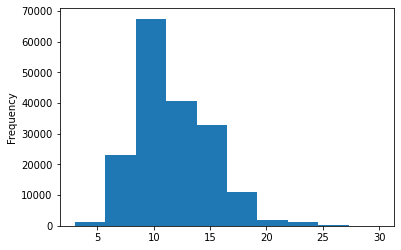

In [ ]:
trainDf.total_lines.plot.hist()

In [ ]:
# Convert abstract text lines into lists 
train_sentences = trainDf["text"].tolist()
dev_sentences = devDf["text"].tolist()
test_sentences = testDf["text"].tolist()
len(train_sentences), len(dev_sentences), len(test_sentences)

(180040, 30212, 30135)

Make numeric labels

In [ ]:
from sklearn.preprocessing import OneHotEncoder

oneHotEncoder = OneHotEncoder(sparse=False)
trainOneHot = oneHotEncoder.fit_transform(trainDf["target"].to_numpy().reshape(-1,1))
testOneHot = oneHotEncoder.transform(testDf["target"].to_numpy().reshape(-1,1))
devOneHot = oneHotEncoder.transform(devDf["target"].to_numpy().reshape(-1,1))

trainOneHot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [ ]:
from sklearn.preprocessing import LabelEncoder

labelEncoder = LabelEncoder()
trainLabel = labelEncoder.fit_transform(trainDf["target"].to_numpy())
testLabel = labelEncoder.transform(testDf["target"].to_numpy())
devLabel = labelEncoder.transform(devDf["target"].to_numpy())

trainLabel

array([3, 2, 2, ..., 4, 1, 1])

##Modelling Experiments

###Evaluation Metrics

In [ ]:
from sklearn.metrics import accuracy_score , precision_recall_fscore_support

def calculateScores(y_pred,y_truth):

  accuracy = accuracy_score(y_pred,y_truth)
  precision,recall,fscore,_ = precision_recall_fscore_support(y_pred,y_truth,average="weighted")

  print(f"""
    Accuracy: {accuracy}
    Precision: {precision}
    Recall: {recall}
    Fscore: {fscore}
  """)

  modelResults = {
    "Accuracy":accuracy,
    "Precision":precision,
    "Recall": recall,
    "Fscore":fscore
  }

  return modelResults



###*Baseline Model: Naive Bayes with Tfidf*

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB

model0 = Pipeline([
      ("tfid",TfidfVectorizer()),
      ("clf",MultinomialNB())
])

model0.fit(train_sentences,trainLabel)

model0Predictions = model0.predict(dev_sentences)

model0Score = model0.score(dev_sentences,devLabel)

model0Results = calculateScores(model0Predictions,devLabel)


    Accuracy: 0.7218323844829869
    Precision: 0.7835634520695112
    Recall: 0.7218323844829869
    Fscore: 0.7447397336209445
  


###Preprocessing Steps for Deep Models

1) Create Tokenization

2) Create Embedding Layer

3) Create tensorflow data API

In [ ]:
import numpy as np

sent_lens = [len(sent.split()) for sent in train_sentences]
avg_len = np.mean(sent_lens)
print(avg_len)

26.338269273494777


(array([4.2075e+04, 8.3771e+04, 3.6877e+04, 1.0945e+04, 3.9310e+03,
        1.4450e+03, 5.6000e+02, 2.2600e+02, 1.0100e+02, 4.5000e+01,
        2.0000e+01, 1.2000e+01, 9.0000e+00, 1.0000e+01, 6.0000e+00,
        2.0000e+00, 3.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([  1.  ,  15.75,  30.5 ,  45.25,  60.  ,  74.75,  89.5 , 104.25,
        119.  , 133.75, 148.5 , 163.25, 178.  , 192.75, 207.5 , 222.25,
        237.  , 251.75, 266.5 , 281.25, 296.  ]),
 <a list of 20 Patch objects>)

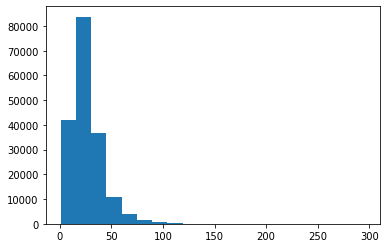

In [ ]:
import matplotlib.pyplot as plt

plt.hist(sent_lens,bins=20)

In [ ]:
outputLen = int(np.percentile(sent_lens,95))
outputLen

55

In [ ]:
max_tokens = 68000

In [ ]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

text_vectorizer = TextVectorization(
    max_tokens = max_tokens,
    output_sequence_length = outputLen,

)

text_vectorizer.adapt(train_sentences)

In [ ]:
import random

sentence = random.choice(train_sentences)
text_vectorizer([sentence])

<tf.Tensor: shape=(1, 55), dtype=int64, numpy=
array([[   43,   138,   534,  1715,     3,  1662,   829,   100,    18,
          702,    38,   479,   754,     3,  4061,    27,    38,  1672,
        28871,     3,  1004,   921,  1047,  1284,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]])>

In [ ]:
words = text_vectorizer.get_vocabulary()
words[0:5]

['', '[UNK]', 'the', 'and', 'of']

In [ ]:
text_vectorizer.get_config()

{'batch_input_shape': (None,),
 'dtype': 'string',
 'idf_weights': None,
 'max_tokens': 68000,
 'name': 'text_vectorization_2',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'ragged': False,
 'sparse': False,
 'split': 'whitespace',
 'standardize': 'lower_and_strip_punctuation',
 'trainable': True,
 'vocabulary': None}

In [ ]:
import tensorflow as tf
token_embedding = tf.keras.layers.Embedding(
    input_dim = len(words),
    output_dim = 128,
    mask_zero = True,
    name = "token_embedding"
)

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences,trainOneHot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences,testOneHot))
dev_dataset = tf.data.Dataset.from_tensor_slices((dev_sentences,devOneHot))

train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
dev_dataset = dev_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
import os

def SaveBestWeights(save_path, model_name):

  filepath = os.path.join(save_path, model_name)

  checkpoint = tf.keras.callbacks.ModelCheckpoint(
      filepath = filepath,
      verbose = 0,
      monitor = 'val_loss',
      save_best_only = True,
      save_freq = 'epoch'
  )

  return checkpoint

###*Model 1: Conv1D with Token Embeddings*

In [ ]:
input_layer = tf.keras.layers.Input(shape=(1,),dtype=tf.string)
text_vectors = text_vectorizer(input_layer)
x = token_embedding(text_vectors)
x = tf.keras.layers.Conv1D(64,kernel_size=5,padding="same",activation="relu")(x)
#x = tf.keras.layers.GlobalAveragePooling1D()(x)
x = tf.keras.layers.Conv1D(64,kernel_size=5,padding="same",activation="relu")(x)
x = tf.keras.layers.GlobalAveragePooling1D()(x)
output_layer = tf.keras.layers.Dense(5,activation="softmax")(x)

model1 = tf.keras.Model(input_layer,output_layer)

model1.compile(
    loss = "categorical_crossentropy",
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["accuracy"]
)

model1History = model1.fit(
    train_dataset,
    steps_per_epoch = int(0.1*len(train_dataset)),
    epochs = 10,
    validation_data = dev_dataset,
    validation_steps=int(0.1 * len(dev_dataset)),
    callbacks=[SaveBestWeights("checkpoints","model_1")]
) 


Epoch 1/10
562/562 [==============================] - 12s 16ms/step - loss: 0.8632 - accuracy: 0.6517 - val_loss: 0.6765 - val_accuracy: 0.7500
Epoch 2/10
562/562 [==============================] - 6s 12ms/step - loss: 0.6580 - accuracy: 0.7541 - val_loss: 0.6464 - val_accuracy: 0.7633
Epoch 3/10
562/562 [==============================] - 7s 13ms/step - loss: 0.6135 - accuracy: 0.7744 - val_loss: 0.5808 - val_accuracy: 0.7932
Epoch 4/10
562/562 [==============================] - 7s 13ms/step - loss: 0.5830 - accuracy: 0.7919 - val_loss: 0.5585 - val_accuracy: 0.7979
Epoch 5/10
562/562 [==============================] - 8s 13ms/step - loss: 0.5804 - accuracy: 0.7938 - val_loss: 0.5371 - val_accuracy: 0.8072
Epoch 6/10
562/562 [==============================] - 7s 13ms/step - loss: 0.5646 - accuracy: 0.7953 - val_loss: 0.5334 - val_accuracy: 0.8132
Epoch 7/10
562/562 [==============================] - 7s 13ms/step - loss: 0.5430 - accuracy: 0.8040 - val_loss: 0.5250 - val_accuracy: 0.817

In [ ]:
model_conv1D = tf.keras.models.load_model('checkpoints/model_1')
model_conv1D_preds = model_conv1D.predict(dev_dataset)
model_conv1D_preds = tf.argmax(model_conv1D_preds,axis=1)
model_conv1D_results = calculateScores(model_conv1D_preds,devLabel)
model_conv1D_results


    Accuracy: 0.8129551171719847
    Precision: 0.8216127486483638
    Recall: 0.8129551171719847
    Fscore: 0.8152078247404279
  


{'Accuracy': 0.8129551171719847,
 'Fscore': 0.8152078247404279,
 'Precision': 0.8216127486483638,
 'Recall': 0.8129551171719847}

In [ ]:
results = pd.DataFrame(
    {"Baseline Naive Bayes":model0Results,
    "Conv1D Token Embeddings":model_conv1D_results
     }
).T

results

,Accuracy,Precision,Recall,Fscore
Baseline Naive Bayes,0.721832,0.783563,0.721832,0.744740
Conv1D Token Embeddings,0.812955,0.821613,0.812955,0.815208


###*Model 2: Tensorflow Hub Feature Extractor*

In [ ]:
import tensorflow_hub as hub

tf_hub_embedding_layer = hub.KerasLayer(
    "https://tfhub.dev/google/universal-sentence-encoder/4",
    trainable=False
)

In [ ]:
input_layer = tf.keras.layers.Input(shape=[],dtype=tf.string)
x = tf_hub_embedding_layer(input_layer)
x = tf.keras.layers.Dense(128,activation='relu')(x)
x = tf.keras.layers.Dense(64,activation='relu')(x)
output_layer = tf.keras.layers.Dense(5,activation="softmax")(x)

model3 = tf.keras.Model(input_layer,output_layer)

model3.compile(
    loss = tf.keras.losses.CategoricalCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["accuracy"]
)

model3History = model3.fit(
    train_dataset,
    epochs = 10,
    steps_per_epoch = int(0.1*len(train_dataset)),
    validation_data = dev_dataset,
    validation_steps = int(0.1*len(dev_dataset)),
    callbacks=[SaveBestWeights("checkpoints","model_2")]
)

Epoch 1/10
560/562 [============================>.] - ETA: 0s - loss: 0.8915 - accuracy: 0.6494INFO:tensorflow:Assets written to: checkpoints/model_2/assets


INFO:tensorflow:Assets written to: checkpoints/model_2/assets


562/562 [==============================] - 20s 31ms/step - loss: 0.8904 - accuracy: 0.6497 - val_loss: 0.7821 - val_accuracy: 0.6955
Epoch 2/10
561/562 [============================>.] - ETA: 0s - loss: 0.7392 - accuracy: 0.7116INFO:tensorflow:Assets written to: checkpoints/model_2/assets


INFO:tensorflow:Assets written to: checkpoints/model_2/assets


562/562 [==============================] - 21s 38ms/step - loss: 0.7390 - accuracy: 0.7117 - val_loss: 0.7172 - val_accuracy: 0.7247
Epoch 3/10
562/562 [==============================] - ETA: 0s - loss: 0.7097 - accuracy: 0.7282INFO:tensorflow:Assets written to: checkpoints/model_2/assets


INFO:tensorflow:Assets written to: checkpoints/model_2/assets


562/562 [==============================] - 22s 39ms/step - loss: 0.7097 - accuracy: 0.7282 - val_loss: 0.6885 - val_accuracy: 0.7377
Epoch 4/10
561/562 [============================>.] - ETA: 0s - loss: 0.6797 - accuracy: 0.7423INFO:tensorflow:Assets written to: checkpoints/model_2/assets


INFO:tensorflow:Assets written to: checkpoints/model_2/assets


562/562 [==============================] - 21s 38ms/step - loss: 0.6796 - accuracy: 0.7423 - val_loss: 0.6658 - val_accuracy: 0.7443
Epoch 5/10
562/562 [==============================] - ETA: 0s - loss: 0.6848 - accuracy: 0.7350INFO:tensorflow:Assets written to: checkpoints/model_2/assets


INFO:tensorflow:Assets written to: checkpoints/model_2/assets


562/562 [==============================] - 22s 39ms/step - loss: 0.6848 - accuracy: 0.7350 - val_loss: 0.6508 - val_accuracy: 0.7480
Epoch 6/10
560/562 [============================>.] - ETA: 0s - loss: 0.6823 - accuracy: 0.7377INFO:tensorflow:Assets written to: checkpoints/model_2/assets


INFO:tensorflow:Assets written to: checkpoints/model_2/assets


562/562 [==============================] - 23s 40ms/step - loss: 0.6818 - accuracy: 0.7378 - val_loss: 0.6425 - val_accuracy: 0.7566
Epoch 7/10
562/562 [==============================] - ETA: 0s - loss: 0.6534 - accuracy: 0.7502INFO:tensorflow:Assets written to: checkpoints/model_2/assets


INFO:tensorflow:Assets written to: checkpoints/model_2/assets


562/562 [==============================] - 21s 38ms/step - loss: 0.6534 - accuracy: 0.7502 - val_loss: 0.6412 - val_accuracy: 0.7557
Epoch 8/10
560/562 [============================>.] - ETA: 0s - loss: 0.6403 - accuracy: 0.7564INFO:tensorflow:Assets written to: checkpoints/model_2/assets


INFO:tensorflow:Assets written to: checkpoints/model_2/assets


562/562 [==============================] - 22s 40ms/step - loss: 0.6423 - accuracy: 0.7559 - val_loss: 0.6223 - val_accuracy: 0.7600
Epoch 9/10
562/562 [==============================] - 9s 16ms/step - loss: 0.6421 - accuracy: 0.7530 - val_loss: 0.6303 - val_accuracy: 0.7560
Epoch 10/10
560/562 [============================>.] - ETA: 0s - loss: 0.6363 - accuracy: 0.7570INFO:tensorflow:Assets written to: checkpoints/model_2/assets


INFO:tensorflow:Assets written to: checkpoints/model_2/assets


562/562 [==============================] - 21s 37ms/step - loss: 0.6369 - accuracy: 0.7567 - val_loss: 0.6218 - val_accuracy: 0.7643


In [ ]:
model3 = tf.keras.models.load_model('checkpoints/model_2')
model3_preds = model3.predict(dev_dataset)
model3_preds = tf.argmax(model3_preds,axis=1)
model_3_results = calculateScores(model3_preds,devLabel)
model_3_results


    Accuracy: 0.7603932212365947
    Precision: 0.771669429797169
    Recall: 0.7603932212365947
    Fscore: 0.7645195771681925
  


{'Accuracy': 0.7603932212365947,
 'Fscore': 0.7645195771681925,
 'Precision': 0.771669429797169,
 'Recall': 0.7603932212365947}

In [ ]:
results = pd.DataFrame(
    {"Baseline Naive Bayes":model0Results,
    "Conv1D Token Embeddings":model_conv1D_results,
    "Tf Hub Feature Extractor":model_3_results
     }
).T

results

,Accuracy,Precision,Recall,Fscore
Baseline Naive Bayes,0.721832,0.783563,0.721832,0.744740
Conv1D Token Embeddings,0.812955,0.821613,0.812955,0.815208
Tf Hub Feature Extractor,0.760393,0.771669,0.760393,0.764520


###*Model3: Conv1D with Char Embeddings*

In [ ]:
def split_chars(text):
  return " ".join(list(text))

In [ ]:
train_chars = [split_chars(sentence) for sentence in train_sentences]
dev_chars = [split_chars(sentence) for sentence in dev_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]

In [ ]:
chars_lens = [len(sentence) for sentence in train_sentences]
mean_lens = np.mean(chars_lens)
mean_lens

149.3662574983337

(array([9.2691e+04, 7.6343e+04, 9.6890e+03, 1.0890e+03, 1.6700e+02,
        4.2000e+01, 1.3000e+01, 3.0000e+00, 2.0000e+00, 1.0000e+00]),
 array([1.0000e+00, 1.3950e+02, 2.7800e+02, 4.1650e+02, 5.5500e+02,
        6.9350e+02, 8.3200e+02, 9.7050e+02, 1.1090e+03, 1.2475e+03,
        1.3860e+03]),
 <a list of 10 Patch objects>)

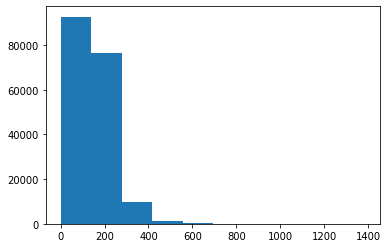

In [ ]:
import matplotlib.pyplot as plt

plt.hist(chars_lens,bins=10)

In [ ]:
output_seq_len = int(np.percentile(chars_lens,95))

In [ ]:
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet
max_tokens = len(alphabet) + 2 #add two for space and OOV

In [ ]:
char_vectorizer = TextVectorization(
    max_tokens = max_tokens,
    output_sequence_length = output_seq_len
)

In [ ]:
char_vectorizer.adapt(train_chars)
char_vocab = char_vectorizer.get_vocabulary()
print(len(char_vocab))
print(char_vocab[:5])

28
['', '[UNK]', 'e', 't', 'i']


In [ ]:
char_embedding = tf.keras.layers.Embedding(
    input_dim = len(char_vocab),
    output_dim = 25,
    mask_zero = True
)

In [ ]:
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars,trainOneHot)).batch(32).prefetch(tf.data.AUTOTUNE)
dev_chars_dataset = tf.data.Dataset.from_tensor_slices((dev_chars,devOneHot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_chars_dataset = tf.data.Dataset.from_tensor_slices((test_chars,testOneHot)).batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
inputs = tf.keras.layers.Input(shape=(1,), dtype="string")
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embedding(char_vectors)
x = tf.keras.layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(char_embeddings)
x = tf.keras.layers.GlobalMaxPool1D()(x)
outputs = tf.keras.layers.Dense(5, activation="softmax")(x)
model_char_embedding = tf.keras.Model(inputs=inputs,
                         outputs=outputs,
                         name="model_3_conv1D_char_embedding")


model_char_embedding.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_char_embedding_history = model_char_embedding.fit(
    train_char_dataset,
    epochs = 10,
    steps_per_epoch = int(0.1*len(train_char_dataset)),
    validation_data = dev_chars_dataset,
    validation_steps = int(0.1*len(dev_chars_dataset)),
    callbacks=[SaveBestWeights("checkpoints","model_char_embedding")]
)

Epoch 1/10
562/562 [==============================] - ETA: 0s - loss: 1.2060 - accuracy: 0.5152INFO:tensorflow:Assets written to: checkpoints/model_char_embedding/assets


INFO:tensorflow:Assets written to: checkpoints/model_char_embedding/assets


562/562 [==============================] - 9s 12ms/step - loss: 1.2060 - accuracy: 0.5152 - val_loss: 1.0148 - val_accuracy: 0.6061
Epoch 2/10
555/562 [============================>.] - ETA: 0s - loss: 0.9682 - accuracy: 0.6185INFO:tensorflow:Assets written to: checkpoints/model_char_embedding/assets


INFO:tensorflow:Assets written to: checkpoints/model_char_embedding/assets


562/562 [==============================] - 5s 9ms/step - loss: 0.9664 - accuracy: 0.6191 - val_loss: 0.9035 - val_accuracy: 0.6516
Epoch 3/10
554/562 [============================>.] - ETA: 0s - loss: 0.8925 - accuracy: 0.6525INFO:tensorflow:Assets written to: checkpoints/model_char_embedding/assets


INFO:tensorflow:Assets written to: checkpoints/model_char_embedding/assets


562/562 [==============================] - 5s 8ms/step - loss: 0.8921 - accuracy: 0.6527 - val_loss: 0.8522 - val_accuracy: 0.6639
Epoch 4/10
559/562 [============================>.] - ETA: 0s - loss: 0.8512 - accuracy: 0.6691INFO:tensorflow:Assets written to: checkpoints/model_char_embedding/assets


INFO:tensorflow:Assets written to: checkpoints/model_char_embedding/assets


562/562 [==============================] - 5s 8ms/step - loss: 0.8513 - accuracy: 0.6691 - val_loss: 0.8215 - val_accuracy: 0.6762
Epoch 5/10
558/562 [============================>.] - ETA: 0s - loss: 0.8380 - accuracy: 0.6734INFO:tensorflow:Assets written to: checkpoints/model_char_embedding/assets


INFO:tensorflow:Assets written to: checkpoints/model_char_embedding/assets


562/562 [==============================] - 5s 9ms/step - loss: 0.8376 - accuracy: 0.6735 - val_loss: 0.8172 - val_accuracy: 0.6789
Epoch 6/10
562/562 [==============================] - ETA: 0s - loss: 0.8220 - accuracy: 0.6805INFO:tensorflow:Assets written to: checkpoints/model_char_embedding/assets


INFO:tensorflow:Assets written to: checkpoints/model_char_embedding/assets


562/562 [==============================] - 5s 8ms/step - loss: 0.8220 - accuracy: 0.6805 - val_loss: 0.7896 - val_accuracy: 0.6932
Epoch 7/10
558/562 [============================>.] - ETA: 0s - loss: 0.8114 - accuracy: 0.6863INFO:tensorflow:Assets written to: checkpoints/model_char_embedding/assets


INFO:tensorflow:Assets written to: checkpoints/model_char_embedding/assets


562/562 [==============================] - 5s 8ms/step - loss: 0.8107 - accuracy: 0.6863 - val_loss: 0.7768 - val_accuracy: 0.6965
Epoch 8/10
557/562 [============================>.] - ETA: 0s - loss: 0.7789 - accuracy: 0.6984INFO:tensorflow:Assets written to: checkpoints/model_char_embedding/assets


INFO:tensorflow:Assets written to: checkpoints/model_char_embedding/assets


562/562 [==============================] - 4s 8ms/step - loss: 0.7793 - accuracy: 0.6984 - val_loss: 0.7761 - val_accuracy: 0.6955
Epoch 9/10
556/562 [============================>.] - ETA: 0s - loss: 0.7747 - accuracy: 0.7019INFO:tensorflow:Assets written to: checkpoints/model_char_embedding/assets


INFO:tensorflow:Assets written to: checkpoints/model_char_embedding/assets


562/562 [==============================] - 5s 8ms/step - loss: 0.7745 - accuracy: 0.7016 - val_loss: 0.7748 - val_accuracy: 0.6971
Epoch 10/10
555/562 [============================>.] - ETA: 0s - loss: 0.7733 - accuracy: 0.7024INFO:tensorflow:Assets written to: checkpoints/model_char_embedding/assets


INFO:tensorflow:Assets written to: checkpoints/model_char_embedding/assets


562/562 [==============================] - 4s 7ms/step - loss: 0.7740 - accuracy: 0.7020 - val_loss: 0.7377 - val_accuracy: 0.7188


In [ ]:
model_char_embedding = tf.keras.models.load_model('checkpoints/model_char_embedding')
model_char_embedding_preds = model_char_embedding.predict(dev_chars_dataset)
model_char_embedding_preds = tf.argmax(model_char_embedding_preds,axis=1)
model_char_embedding_results = calculateScores(model_char_embedding_preds,devLabel)
model_char_embedding_results


    Accuracy: 0.7180259499536608
    Precision: 0.7340126547624576
    Recall: 0.7180259499536608
    Fscore: 0.7242548635799906
  


{'Accuracy': 0.7180259499536608,
 'Fscore': 0.7242548635799906,
 'Precision': 0.7340126547624576,
 'Recall': 0.7180259499536608}

In [ ]:
results = pd.DataFrame(
    {"Baseline Naive Bayes":model0Results,
    "Conv1D Token Embeddings":model_conv1D_results,
    "Tf Hub Feature Extractor":model_3_results,
    "Conv1D with Char Embedding":model_char_embedding_results
     }
).T

results

,Accuracy,Precision,Recall,Fscore
Baseline Naive Bayes,0.721832,0.783563,0.721832,0.744740
Conv1D Token Embeddings,0.812955,0.821613,0.812955,0.815208
Tf Hub Feature Extractor,0.760393,0.771669,0.760393,0.764520
Conv1D with Char Embedding,0.718026,0.734013,0.718026,0.724255


###*Model4: Combining pretrained token embeddings + character embeddings (hybrid embedding layer)*

In [ ]:
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars))
train_char_token_labels = tf.data.Dataset.from_tensor_slices(devOneHot)
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels))
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) 

val_char_token_data = tf.data.Dataset.from_tensor_slices((dev_sentences, dev_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(devOneHot)
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels))
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
# 1. Setup token inputs/model
token_inputs = tf.keras.layers.Input(shape=[], dtype=tf.string, name="token_input")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_output = tf.keras.layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_output)

# 2. Setup char inputs/model
char_inputs = tf.keras.layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embedding(char_vectors)
char_bi_lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(25))(char_embeddings) # bi-LSTM shown in Figure 1 of https://arxiv.org/pdf/1612.05251.pdf
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Concatenate token and char inputs (create hybrid token embedding)
token_char_concat = tf.keras.layers.Concatenate(name="token_char_hybrid")([token_model.output, 
                                                                  char_model.output])

# 4. Create output layers - addition of dropout discussed in 4.2 of https://arxiv.org/pdf/1612.05251.pdf
combined_dropout = tf.keras.layers.Dropout(0.5)(token_char_concat)
combined_dense = tf.keras.layers.Dense(200, activation="relu")(combined_dropout) # slightly different to Figure 1 due to different shapes of token/char embedding layers
final_dropout = tf.keras.layers.Dropout(0.5)(combined_dense)
output_layer = tf.keras.layers.Dense(5, activation="softmax")(final_dropout)

model_4_token_and_char_embeddings = tf.keras.Model(inputs=[token_model.input, char_model.input],
                         outputs=output_layer,
                         name="model_4_token_and_char_embeddings")

model_4_token_and_char_embeddings.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_4_token_and_char_embeddings_history = model_4_token_and_char_embeddings.fit(
    train_char_token_dataset,
    epochs = 10,
    steps_per_epoch = int(0.1*len(train_char_token_dataset)),
    validation_data = val_char_token_dataset,
    validation_steps = int(0.1*len(val_char_token_dataset)),
    callbacks=[SaveBestWeights("checkpoints","model_4_token_and_char_embeddings")]
)

Epoch 1/10
562/562 [==============================] - ETA: 0s - loss: 0.9703 - accuracy: 0.6162

INFO:tensorflow:Assets written to: checkpoints/model_4_token_and_char_embeddings/assets


INFO:tensorflow:Assets written to: checkpoints/model_4_token_and_char_embeddings/assets


562/562 [==============================] - 78s 120ms/step - loss: 0.9703 - accuracy: 0.6162 - val_loss: 0.7773 - val_accuracy: 0.6951
Epoch 2/10
562/562 [==============================] - ETA: 0s - loss: 0.7920 - accuracy: 0.6950

INFO:tensorflow:Assets written to: checkpoints/model_4_token_and_char_embeddings/assets


INFO:tensorflow:Assets written to: checkpoints/model_4_token_and_char_embeddings/assets


562/562 [==============================] - 77s 136ms/step - loss: 0.7920 - accuracy: 0.6950 - val_loss: 0.7171 - val_accuracy: 0.7294
Epoch 3/10
562/562 [==============================] - ETA: 0s - loss: 0.7665 - accuracy: 0.7065

INFO:tensorflow:Assets written to: checkpoints/model_4_token_and_char_embeddings/assets


INFO:tensorflow:Assets written to: checkpoints/model_4_token_and_char_embeddings/assets


562/562 [==============================] - 62s 110ms/step - loss: 0.7665 - accuracy: 0.7065 - val_loss: 0.6903 - val_accuracy: 0.7387
Epoch 4/10
561/562 [============================>.] - ETA: 0s - loss: 0.7347 - accuracy: 0.7211

INFO:tensorflow:Assets written to: checkpoints/model_4_token_and_char_embeddings/assets


INFO:tensorflow:Assets written to: checkpoints/model_4_token_and_char_embeddings/assets


562/562 [==============================] - 64s 114ms/step - loss: 0.7347 - accuracy: 0.7211 - val_loss: 0.6648 - val_accuracy: 0.7493
Epoch 5/10
562/562 [==============================] - ETA: 0s - loss: 0.7408 - accuracy: 0.7189

INFO:tensorflow:Assets written to: checkpoints/model_4_token_and_char_embeddings/assets


INFO:tensorflow:Assets written to: checkpoints/model_4_token_and_char_embeddings/assets


562/562 [==============================] - 61s 109ms/step - loss: 0.7408 - accuracy: 0.7189 - val_loss: 0.6581 - val_accuracy: 0.7473
Epoch 6/10
561/562 [============================>.] - ETA: 0s - loss: 0.7390 - accuracy: 0.7229

INFO:tensorflow:Assets written to: checkpoints/model_4_token_and_char_embeddings/assets


INFO:tensorflow:Assets written to: checkpoints/model_4_token_and_char_embeddings/assets


562/562 [==============================] - 62s 110ms/step - loss: 0.7386 - accuracy: 0.7229 - val_loss: 0.6489 - val_accuracy: 0.7540
Epoch 7/10
562/562 [==============================] - ETA: 0s - loss: 0.7087 - accuracy: 0.7297

INFO:tensorflow:Assets written to: checkpoints/model_4_token_and_char_embeddings/assets


INFO:tensorflow:Assets written to: checkpoints/model_4_token_and_char_embeddings/assets


562/562 [==============================] - 65s 116ms/step - loss: 0.7087 - accuracy: 0.7297 - val_loss: 0.6380 - val_accuracy: 0.7616
Epoch 8/10
562/562 [==============================] - ETA: 0s - loss: 0.7009 - accuracy: 0.7353

INFO:tensorflow:Assets written to: checkpoints/model_4_token_and_char_embeddings/assets


INFO:tensorflow:Assets written to: checkpoints/model_4_token_and_char_embeddings/assets


562/562 [==============================] - 63s 112ms/step - loss: 0.7009 - accuracy: 0.7353 - val_loss: 0.6268 - val_accuracy: 0.7650
Epoch 9/10
562/562 [==============================] - 30s 54ms/step - loss: 0.7039 - accuracy: 0.7360 - val_loss: 0.6372 - val_accuracy: 0.7547
Epoch 10/10
561/562 [============================>.] - ETA: 0s - loss: 0.7036 - accuracy: 0.7396

INFO:tensorflow:Assets written to: checkpoints/model_4_token_and_char_embeddings/assets


INFO:tensorflow:Assets written to: checkpoints/model_4_token_and_char_embeddings/assets


562/562 [==============================] - 60s 107ms/step - loss: 0.7037 - accuracy: 0.7394 - val_loss: 0.6198 - val_accuracy: 0.7656


In [ ]:
model_4_token_and_char_embeddings = tf.keras.models.load_model('checkpoints/model_4_token_and_char_embeddings')
model_4_token_and_char_embeddings_preds = model_4_token_and_char_embeddings.predict(val_char_token_dataset)
model_4_token_and_char_embeddings_preds = tf.argmax(model_4_token_and_char_embeddings_preds,axis=1)
model_4_token_and_char_embeddings_results = calculateScores(model_4_token_and_char_embeddings_preds,devLabel)
model_4_token_and_char_embeddings_results


    Accuracy: 0.7609559115583212
    Precision: 0.7739318747164167
    Recall: 0.7609559115583212
    Fscore: 0.7652383204653312
  


{'Accuracy': 0.7609559115583212,
 'Fscore': 0.7652383204653312,
 'Precision': 0.7739318747164167,
 'Recall': 0.7609559115583212}

In [ ]:
results = pd.DataFrame(
    {"Baseline Naive Bayes":model0Results,
    "Conv1D Token Embeddings":model_conv1D_results,
    "Tf Hub Feature Extractor":model_3_results,
    "Conv1D with Char Embedding":model_char_embedding_results,
    "Char and Token Embeddings":model_4_token_and_char_embeddings_results
     }
).T

results

,Accuracy,Precision,Recall,Fscore
Baseline Naive Bayes,0.721832,0.783563,0.721832,0.744740
Conv1D Token Embeddings,0.812955,0.821613,0.812955,0.815208
Tf Hub Feature Extractor,0.760393,0.771669,0.760393,0.764520
Conv1D with Char Embedding,0.718026,0.734013,0.718026,0.724255
Char and Token Embeddings,0.760956,0.773932,0.760956,0.765238


###*Model5:Transfer Learning with pretrained token embeddings + character embeddings + positional embeddings*


The "line_number" and "total_lines" columns are features which didn't necessarily come with the training data but can be passed to our model as a positional embedding. In other words, the positional embedding is where the sentence appears in an abstract.

In [ ]:
# How many different line numbers are there?
trainDf["line_number"].value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

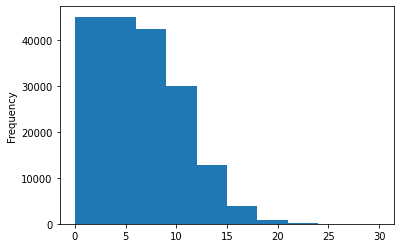

In [ ]:
trainDf.line_number.plot.hist()

In [ ]:
# Use TensorFlow to create one-hot-encoded tensors of our "line_number" column 
train_line_numbers_one_hot = tf.one_hot(trainDf["line_number"].to_numpy(), depth=15)
val_line_numbers_one_hot = tf.one_hot(devDf["line_number"].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(testDf["line_number"].to_numpy(), depth=15)

In [ ]:
# How many different numbers of lines are there?
trainDf["total_lines"].value_counts()

11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: total_lines, dtype: int64

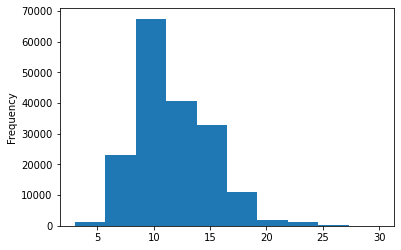

In [ ]:
trainDf.total_lines.plot.hist()

In [ ]:
# Check the coverage of a "total_lines" value of 20
np.percentile(trainDf.total_lines, 98) # a value of 20 covers 98% of samples

20.0

In [ ]:
# Use TensorFlow to create one-hot-encoded tensors of our "total_lines" column 
train_total_lines_one_hot = tf.one_hot(trainDf["total_lines"].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(devDf["total_lines"].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(testDf["total_lines"].to_numpy(), depth=20)

We are going to build the following model:

Create a token-level model (similar to model_1)
Create a character-level model (similar to model_3 with a slight modification to reflect the paper)

Create a "line_number" model (takes in one-hot-encoded "line_number" tensor and passes it through a non-linear layer)

Create a "total_lines" model (takes in one-hot-encoded "total_lines" tensor and passes it through a non-linear layer)

Combine (using layers.Concatenate) the outputs of 1 and 2 into a token-character-hybrid embedding and pass it series of output to Figure 1 and section 4.2 of Neural Networks for Joint Sentence Classification in Medical Paper Abstracts

Combine (using layers.Concatenate) the outputs of 3, 4 and 5 into a token-character-positional tribrid embedding

Create an output layer to accept the tribrid embedding and output predicted label probabilities

Combine the inputs of 1, 2, 3, 4 and outputs of 7 into a tf.keras.Model

In [ ]:
# 1. Token inputs
token_inputs = tf.keras.layers.Input(shape=[], dtype="string", name="token_inputs")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = tf.keras.layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_outputs)

# 2. Char inputs
char_inputs = tf.keras.layers.Input(shape=(1,), dtype="string", name="char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embedding(char_vectors)
char_bi_lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Line numbers inputs
line_number_inputs = tf.keras.layers.Input(shape=(15,), dtype=tf.int32, name="line_number_input")
x = tf.keras.layers.Dense(32, activation="relu")(line_number_inputs)
line_number_model = tf.keras.Model(inputs=line_number_inputs,
                                   outputs=x)

# 4. Total lines inputs
total_lines_inputs = tf.keras.layers.Input(shape=(20,), dtype=tf.int32, name="total_lines_input")
y = tf.keras.layers.Dense(32, activation="relu")(total_lines_inputs)
total_line_model = tf.keras.Model(inputs=total_lines_inputs,
                                  outputs=y)

# 5. Combine token and char embeddings into a hybrid embedding
combined_embeddings = tf.keras.layers.Concatenate(name="token_char_hybrid_embedding")([token_model.output, 
                                                                              char_model.output])
z = tf.keras.layers.Dense(256, activation="relu")(combined_embeddings)
z = tf.keras.layers.Dropout(0.5)(z)

# 6. Combine positional embeddings with combined token and char embeddings into a tribrid embedding
z = tf.keras.layers.Concatenate(name="token_char_positional_embedding")([line_number_model.output,
                                                                total_line_model.output,
                                                                z])

# 7. Create output layer
output_layer = tf.keras.layers.Dense(5, activation="softmax", name="output_layer")(z)

# 8. Put together model
model_5 = tf.keras.Model(inputs=[line_number_model.input,
                                 total_line_model.input,
                                 token_model.input, 
                                 char_model.input],
                         outputs=output_layer)

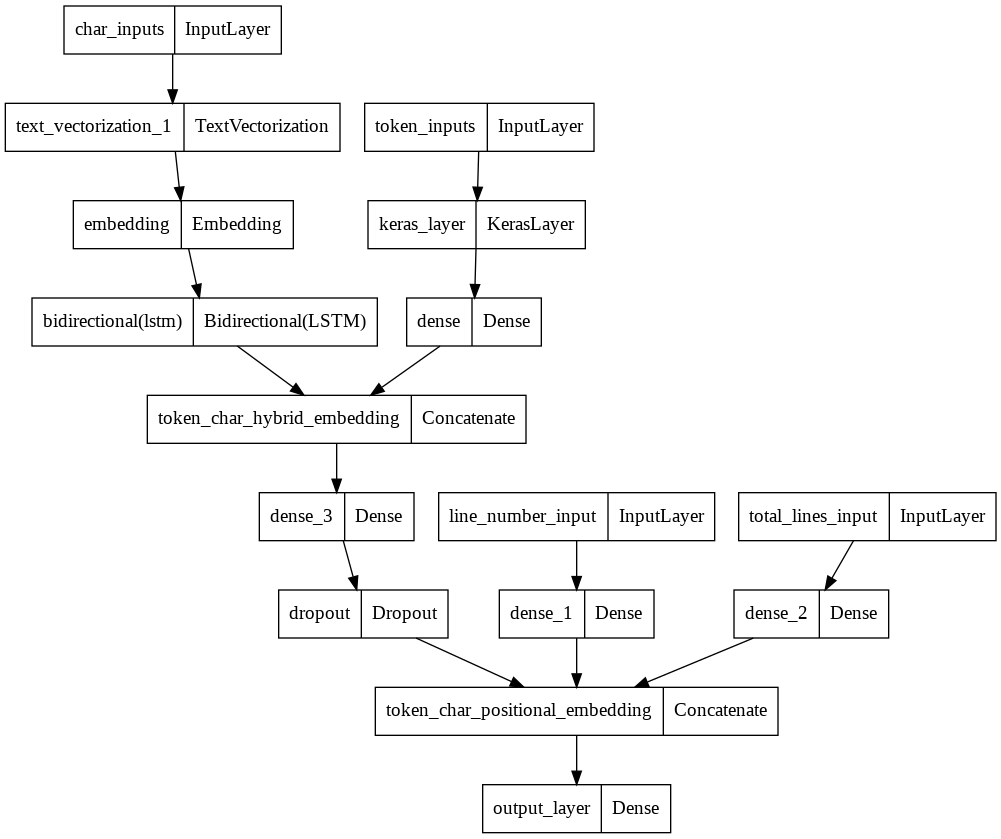

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(model_5)

In [ ]:
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), # add label smoothing (examples which are really confident get smoothed a little)
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
# Create training and validation datasets (all four kinds of inputs)
train_pos_char_token_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot, # line numbers
                                                                train_total_lines_one_hot, # total lines
                                                                train_sentences, # train tokens
                                                                train_chars)) # train chars
train_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(trainOneHot) # train labels
train_pos_char_token_dataset = tf.data.Dataset.zip((train_pos_char_token_data, train_pos_char_token_labels)) # combine data and labels
train_pos_char_token_dataset = train_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

# Validation dataset
val_pos_char_token_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                              val_total_lines_one_hot,
                                                              dev_sentences,
                                                              dev_chars))
val_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(devOneHot)
val_pos_char_token_dataset = tf.data.Dataset.zip((val_pos_char_token_data, val_pos_char_token_labels))
val_pos_char_token_dataset = val_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

# Check input shapes
train_pos_char_token_dataset, val_pos_char_token_dataset

(<PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [ ]:
model_5_position_embeddings_history = model_5.fit(
    train_pos_char_token_dataset,
    epochs = 10,
    steps_per_epoch = int(0.1*len(train_pos_char_token_dataset)),
    validation_data = val_pos_char_token_dataset,
    validation_steps = int(0.1*len(val_pos_char_token_dataset)),
    callbacks=[SaveBestWeights("checkpoints","model_5_position_embeddings")]
)

Epoch 1/10
561/562 [============================>.] - ETA: 0s - loss: 1.0935 - accuracy: 0.7285

INFO:tensorflow:Assets written to: checkpoints/model_5_position_embeddings/assets


INFO:tensorflow:Assets written to: checkpoints/model_5_position_embeddings/assets


562/562 [==============================] - 76s 120ms/step - loss: 1.0931 - accuracy: 0.7288 - val_loss: 0.9803 - val_accuracy: 0.8075
Epoch 2/10
562/562 [==============================] - ETA: 0s - loss: 0.9669 - accuracy: 0.8151

INFO:tensorflow:Assets written to: checkpoints/model_5_position_embeddings/assets


INFO:tensorflow:Assets written to: checkpoints/model_5_position_embeddings/assets


562/562 [==============================] - 82s 146ms/step - loss: 0.9669 - accuracy: 0.8151 - val_loss: 0.9490 - val_accuracy: 0.8308
Epoch 3/10
561/562 [============================>.] - ETA: 0s - loss: 0.9499 - accuracy: 0.8251

INFO:tensorflow:Assets written to: checkpoints/model_5_position_embeddings/assets


INFO:tensorflow:Assets written to: checkpoints/model_5_position_embeddings/assets


562/562 [==============================] - 61s 108ms/step - loss: 0.9499 - accuracy: 0.8250 - val_loss: 0.9386 - val_accuracy: 0.8334
Epoch 4/10
561/562 [============================>.] - ETA: 0s - loss: 0.9395 - accuracy: 0.8364

INFO:tensorflow:Assets written to: checkpoints/model_5_position_embeddings/assets


INFO:tensorflow:Assets written to: checkpoints/model_5_position_embeddings/assets


562/562 [==============================] - 66s 117ms/step - loss: 0.9395 - accuracy: 0.8364 - val_loss: 0.9300 - val_accuracy: 0.8308
Epoch 5/10
562/562 [==============================] - ETA: 0s - loss: 0.9370 - accuracy: 0.8342

INFO:tensorflow:Assets written to: checkpoints/model_5_position_embeddings/assets


INFO:tensorflow:Assets written to: checkpoints/model_5_position_embeddings/assets


562/562 [==============================] - 64s 113ms/step - loss: 0.9370 - accuracy: 0.8342 - val_loss: 0.9254 - val_accuracy: 0.8378
Epoch 6/10
562/562 [==============================] - ETA: 0s - loss: 0.9400 - accuracy: 0.8300

INFO:tensorflow:Assets written to: checkpoints/model_5_position_embeddings/assets


INFO:tensorflow:Assets written to: checkpoints/model_5_position_embeddings/assets


562/562 [==============================] - 64s 114ms/step - loss: 0.9400 - accuracy: 0.8300 - val_loss: 0.9198 - val_accuracy: 0.8467
Epoch 7/10
562/562 [==============================] - 33s 59ms/step - loss: 0.9289 - accuracy: 0.8382 - val_loss: 0.9253 - val_accuracy: 0.8391
Epoch 8/10
561/562 [============================>.] - ETA: 0s - loss: 0.9228 - accuracy: 0.8423

INFO:tensorflow:Assets written to: checkpoints/model_5_position_embeddings/assets


INFO:tensorflow:Assets written to: checkpoints/model_5_position_embeddings/assets


562/562 [==============================] - 60s 107ms/step - loss: 0.9229 - accuracy: 0.8422 - val_loss: 0.9083 - val_accuracy: 0.8521
Epoch 9/10
562/562 [==============================] - 31s 55ms/step - loss: 0.9263 - accuracy: 0.8415 - val_loss: 0.9197 - val_accuracy: 0.8451
Epoch 10/10
562/562 [==============================] - 28s 50ms/step - loss: 0.9229 - accuracy: 0.8438 - val_loss: 0.9111 - val_accuracy: 0.8444


In [ ]:
model_5_position_embeddings = tf.keras.models.load_model('checkpoints/model_5_position_embeddings')
model_5_position_embeddings_preds = model_5_position_embeddings.predict(val_pos_char_token_dataset)
model_5_position_embeddings_preds = tf.argmax(model_5_position_embeddings_preds,axis=1)
model_5_position_embeddings_results = calculateScores(model_5_position_embeddings_preds,devLabel)
model_5_position_embeddings_results


    Accuracy: 0.8521117436780088
    Precision: 0.8592761432241123
    Recall: 0.8521117436780088
    Fscore: 0.8541156508236543
  


{'Accuracy': 0.8521117436780088,
 'Fscore': 0.8541156508236543,
 'Precision': 0.8592761432241123,
 'Recall': 0.8521117436780088}

##Comparing Models

In [ ]:
results = pd.DataFrame(
    {"Baseline Naive Bayes":model0Results,
    "Conv1D Token Embeddings":model_conv1D_results,
    "Tf Hub Feature Extractor":model_3_results,
    "Conv1D with Char Embedding":model_char_embedding_results,
    "Char and Token Embeddings":model_4_token_and_char_embeddings_results,
    "Positional Embeddings":model_5_position_embeddings_results
     }
).T

results

,Accuracy,Precision,Recall,Fscore
Baseline Naive Bayes,0.721832,0.783563,0.721832,0.744740
Conv1D Token Embeddings,0.812955,0.821613,0.812955,0.815208
Tf Hub Feature Extractor,0.760393,0.771669,0.760393,0.764520
Conv1D with Char Embedding,0.718026,0.734013,0.718026,0.724255
Char and Token Embeddings,0.760956,0.773932,0.760956,0.765238
Positional Embeddings,0.852112,0.859276,0.852112,0.854116


The Positional Embeddings Model is performing the best on the given dataset

In [ ]:
test_pos_char_token_data = tf.data.Dataset.from_tensor_slices((test_line_numbers_one_hot,
                                                               test_total_lines_one_hot,
                                                               test_sentences,
                                                               test_chars))
test_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(testOneHot)
test_pos_char_token_dataset = tf.data.Dataset.zip((test_pos_char_token_data, test_pos_char_token_labels))
test_pos_char_token_dataset = test_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

test_pos_char_token_dataset

<PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [ ]:
test_pred_probs = model_5_position_embeddings.predict(test_pos_char_token_dataset,verbose=1)
test_preds = tf.argmax(test_pred_probs, axis=1)
loaded_model_test_results = calculateScores(testLabel,test_preds)
loaded_model_test_results

942/942 [==============================] - 24s 25ms/step

    Accuracy: 0.8455284552845529
    Precision: 0.8444907201950325
    Recall: 0.8455284552845529
    Fscore: 0.8434452050269997
  


{'Accuracy': 0.8455284552845529,
 'Fscore': 0.8434452050269997,
 'Precision': 0.8444907201950325,
 'Recall': 0.8455284552845529}

In [ ]:
test_pred_classes = [labelEncoder.classes_[pred] for pred in test_preds]
test_pred_classes

['OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'BACKGROUND',
 'OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'BACKGROUND',
 'OBJECTIVE',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'BACKGROUND',
 'METHODS',
 'BACKGROUND',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'BACKGROUND',
 'BACKGROUND',
 'BACKGROUND',
 'OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'R